In [98]:
import pandas as pd
df1=pd.read_excel('UDJG_ADULT_CONS1.xls')
df2=pd.read_excel('UDJG_ADULT_CONS2.xls')
df3=pd.read_excel('UDJG_ADULT_CONS3.xls')
df4=pd.read_excel('UDJG_ADULT_CONS4.xls')
dataset2=pd.read_excel('UDJG_ADULT_FOODS.xls')
dataset3=pd.read_excel('UDJG_ADULT_SUBJ.xls')

dataset = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)
#dataset = pd.read_excel('UDJG_ADULT_CONS1.xls')

In [99]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
import random
from collections import Counter
import numpy as np

In [100]:
columns_to_delete=['SURVEY', 'CONDAY', 'CONMONTH', 'CONYEAR', 'EXCEPTIONDAY', 'TIMEHOUR', 
                   'TIMEMINUTES', 'UNITMEAS', 'BRAND', 'ORFACETSCODE', 'ORFACETS', 'ENFACETS', 'PACKAGE', 'OFACETS', 'ORRECIPECODE', 
                   'ENRECIPEDESC', 'AMOUNTRECIPE', 'FPREP', 'FOODEXRCODE']
dataset=dataset.drop(columns=columns_to_delete, axis=1)


columns_to_delete2=['SURVEY', 'COMMENTSFOOD', 'ENERGY', 'WATER', 'FAT', 'CARB', 'PROTEINS', 'ALCOHOL', 'ENFOODNAME', 'FOODEXCODE']
dataset2=dataset2.drop(columns=columns_to_delete2, axis=1)

columns_to_delete3=['SURVEY', 'COUNTRY', 'BIRTHDAY', 'BIRTHMONTH', 'BIRTHYEAR', 'FANTYEAR', 'SWEIGHT', 'SHEIGHT', 'SANTDAY', 'SANTMONTH', 'SANTYEAR', 'MWEIGHT', 
                    'MHEIGHT', 'ENRGYINTAKE', 'UNOVREP', 'WF', 'SPECIALCON', 'SPECDIET', 'ACTIVITY', 'ETHNIC', 'FANTMONTH', 'FANTDAY',
                    'EDUCATION', 'COMMENTSSUBJECT']
dataset3=dataset3.drop(columns=columns_to_delete3, axis=1)

In [101]:
dataset.head(10)

,ORSUBCODE,DAY,WEEK,SEASON,MEAL,PLACE,EATSEQ,ORRECIPEDESC,ORFOODCODE,AMOUNTFRAW,AMOUNTFCOOKED
0,F001,1,W1,S5,M1,P3,1,NaN,207.1.1.6.0,25.0,25.0
1,F001,1,W1,S5,M1,P3,1,NaN,204.1.2.5.0,25.0,25.0
2,F001,1,W1,S5,M1,P3,2,NaN,101.1.1.1.0,250.0,250.0
3,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),204.2.2.2.1,3.0,3.0
4,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),414.0.0.0.1,100.0,100.0
5,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),108.1.1.1.0,50.0,36.5
6,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),204.2.1.3.0,30.0,25.2
7,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),204.2.1.8.0,40.0,32.8
8,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),206.1.2.0.0,5.0,15.0
9,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),110.1.0.0.0,20.0,20.0


In [102]:
columns_to_check_duplicates = ['ORSUBCODE', 'DAY', 'WEEK', 'SEASON', 'MEAL', 'PLACE', 'EATSEQ']
condition_not_empty = dataset['ORRECIPEDESC'].notna()

dataset_no_duplicates = dataset[condition_not_empty].drop_duplicates(subset=columns_to_check_duplicates, keep=False)
dataset_no_duplicates = pd.concat([dataset[~condition_not_empty], dataset_no_duplicates])

In [103]:
dataset_no_duplicates.head(10)

,ORSUBCODE,DAY,WEEK,SEASON,MEAL,PLACE,EATSEQ,ORRECIPEDESC,ORFOODCODE,AMOUNTFRAW,AMOUNTFCOOKED
0,F001,1,W1,S5,M1,P3,1,NaN,207.1.1.6.0,25.0,25.0
1,F001,1,W1,S5,M1,P3,1,NaN,204.1.2.5.0,25.0,25.0
2,F001,1,W1,S5,M1,P3,2,NaN,101.1.1.1.0,250.0,250.0
24,F001,1,W1,S5,M3,P3,2,NaN,207.1.1.6.0,50.0,50.0
27,F001,1,W1,S5,M7,P3,1,NaN,414.1.5.1.0,75.0,75.0
28,F001,1,W1,S5,M7,P3,2,NaN,204.1.1.9.0,100.0,100.0
51,F001,2,W2,S5,M3,P3,2,NaN,108.2.2.2.17,121.0,85.0
52,F001,2,W2,S5,M3,P3,2,NaN,207.1.1.6.0,25.0,25.0
53,F001,2,W2,S5,M5,P3,1,NaN,101.1.2.0.1,175.0,175.0
54,F001,2,W2,S5,M7,P3,1,NaN,204.1.1.2.0,118.0,118.0


In [104]:
foodcode_to_recipe = dataset2.set_index('ORFOODCODE')['ORFOODNAME'].to_dict()

mask = pd.isna(dataset_no_duplicates['ORRECIPEDESC'])
dataset_no_duplicates.loc[mask, 'ORRECIPEDESC'] = dataset_no_duplicates.loc[mask, 'ORFOODCODE'].map(foodcode_to_recipe)

dataset_no_duplicates.insert(loc=11, column='GENDER', value='')
dataset_no_duplicates.insert(loc=12, column='AGE', value='')
dataset_no_duplicates.insert(loc=13, column='WEIGHT', value='')
dataset_no_duplicates.insert(loc=14, column='HEIGHT', value='')
dataset_no_duplicates.insert(loc=15, column='GEO', value='')


In [105]:
gender_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['GENDER']
age_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['AGE']
weight_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['WEIGHT']
height_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['HEIGHT']
geo_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['GEO']

dataset_no_duplicates.loc[:, 'GENDER'] = dataset_no_duplicates['ORSUBCODE'].map(gender_to_recipe)
dataset_no_duplicates.loc[:, 'AGE'] = dataset_no_duplicates['ORSUBCODE'].map(age_to_recipe)
dataset_no_duplicates.loc[:, 'WEIGHT'] = dataset_no_duplicates['ORSUBCODE'].map(weight_to_recipe)
dataset_no_duplicates.loc[:, 'HEIGHT'] = dataset_no_duplicates['ORSUBCODE'].map(height_to_recipe)
dataset_no_duplicates.loc[:, 'GEO'] = dataset_no_duplicates['ORSUBCODE'].map(geo_to_recipe)


In [106]:
dataset_no_duplicates.loc[:, 'WEEK'] = dataset_no_duplicates['WEEK'].str.replace('W', '').astype(int)
dataset_no_duplicates.loc[:, 'SEASON'] = dataset_no_duplicates['SEASON'].str.replace('S', '').astype(int)
dataset_no_duplicates.loc[:, 'MEAL'] = dataset_no_duplicates['MEAL'].str.replace('M', '').astype(int)
dataset_no_duplicates.loc[:, 'PLACE'] = dataset_no_duplicates['PLACE'].str.replace('P', '').astype(int)
dataset_no_duplicates.loc[:, 'GENDER'] = dataset_no_duplicates['GENDER'].str.replace('G', '').astype(int)
dataset_no_duplicates.loc[:, 'GEO'] = dataset_no_duplicates['GEO'].str.replace('RO', '').astype(int)

In [107]:
columns_to_delete=['ORFOODCODE', 'ORSUBCODE']
dataset_no_duplicates=dataset_no_duplicates.drop(columns=columns_to_delete, axis=1)


In [108]:
le = LabelEncoder()
#dataset['ORRECIPEDESC'] = le.fit_transform(dataset['ORRECIPEDESC'])
dataset_no_duplicates['ORRECIPEDESC_encoded'] = le.fit_transform(dataset_no_duplicates['ORRECIPEDESC'])


In [109]:
dataset_no_duplicates['BMI'] = np.ceil((dataset_no_duplicates['WEIGHT'] / (dataset_no_duplicates['HEIGHT'] / 100) ** 2))

In [110]:
dataset_no_duplicates.head()

,DAY,WEEK,SEASON,MEAL,PLACE,EATSEQ,ORRECIPEDESC,AMOUNTFRAW,AMOUNTFCOOKED,GENDER,AGE,WEIGHT,HEIGHT,GEO,ORRECIPEDESC_encoded,BMI
0,1,1,5,1,3,1,paine,25.0,25.0,2,34,64.0,164,126,708,24
1,1,1,5,1,3,1,dulceata,25.0,25.0,2,34,64.0,164,126,448,24
2,1,1,5,1,3,2,lapte,250.0,250.0,2,34,64.0,164,126,602,24
24,1,1,5,3,3,2,paine,50.0,50.0,2,34,64.0,164,126,708,24
27,1,1,5,7,3,1,cafea preparata,75.0,75.0,2,34,64.0,164,126,123,24


In [111]:
#dataset_no_duplicates=dataset_no_duplicates.sample(frac=1, random_state=42)
#dataset_no_duplicates.reset_index(drop=True, inplace=True)

In [112]:
interest = dataset_no_duplicates.iloc[:, [col for col in range(dataset_no_duplicates.shape[1]) if col != 6]].values

# standardize data (mean = 0, std dev = 1)
scaler = StandardScaler()
interest_z = scaler.fit_transform(interest)

In [113]:

# presupunem că aveți un DataFrame numit dataset_no_duplicates

def classify_bmi(row):
    bmi = row['BMI']
    if bmi < 16:
        return 'Severe Thinness'
    elif 16 <= bmi < 17:
        return 'Moderate Thinness'
    elif 17 <= bmi < 18.5:
        return 'Mild Thinness'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obese Class I'
    elif 35 <= bmi < 40:
        return 'Obese Class II'
    elif bmi >= 40:
        return 'Obese Class III'
    else:
        return 'Unknown'  # pentru valorile NaN sau nevalide

# Aplicarea funcției de clasificare
dataset_no_duplicates['WeightClassification'] = dataset_no_duplicates.apply(classify_bmi, axis=1)

In [114]:
# apply k-means
random.seed(2345)

kmeans = KMeans(init="random", n_clusters=5, n_init=10, max_iter=300,random_state=42)
kmeans = KMeans(n_clusters=5)
kmeans.fit(interest_z)

kmeans.n_iter_
kmeans.cluster_centers_

dataset_no_duplicates['cluster'] = kmeans.labels_
Counter(dataset_no_duplicates['cluster'])

C:\Users\ca222\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({0: 19447, 1: 18983, 4: 15263, 2: 14147, 3: 1702})

In [115]:
# Gruparea datelor și calcularea frecvenței fiecărei rețete în fiecare cluster și GEO
popular_recipes = dataset_no_duplicates.groupby(['cluster', 'WeightClassification'])['ORRECIPEDESC'].value_counts()

# Obținerea top 5 rețete pentru fiecare combinație de cluster și GEO
top5_recipes_per_cluster_geo = popular_recipes.groupby(level=[0, 1]).nlargest(5).reset_index(level=[0, 1], drop=True)

# Afișarea rezultatelor
top5_recipes_per_cluster_geo.to_csv('statistica1.csv')

In [116]:
dataset_no_duplicates

,DAY,WEEK,SEASON,MEAL,PLACE,EATSEQ,ORRECIPEDESC,AMOUNTFRAW,AMOUNTFCOOKED,GENDER,AGE,WEIGHT,HEIGHT,GEO,ORRECIPEDESC_encoded,BMI,WeightClassification,cluster
0,1,1,5,1,3,1,paine,25.0,25.0,2,34,64.0,164,126,708,24,Normal,0
1,1,1,5,1,3,1,dulceata,25.0,25.0,2,34,64.0,164,126,448,24,Normal,0
2,1,1,5,1,3,2,lapte,250.0,250.0,2,34,64.0,164,126,602,24,Normal,0
24,1,1,5,3,3,2,paine,50.0,50.0,2,34,64.0,164,126,708,24,Normal,0
27,1,1,5,7,3,1,cafea preparata,75.0,75.0,2,34,64.0,164,126,123,24,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237387,1,1,2,1,1,1,iaurt cu cereale,125.0,125.0,2,47,68.0,170,423,570,24,Normal,0
237417,2,2,2,1,1,1,iaurt cu cereale,125.0,125.0,2,47,68.0,170,423,570,24,Normal,0
237477,4,4,2,1,1,1,iaurt cu cereale,125.0,125.0,2,47,68.0,170,423,570,24,Normal,0
237523,6,6,2,1,1,1,iaurt cu cereale,125.0,125.0,2,47,68.0,170,423,570,24,Normal,4


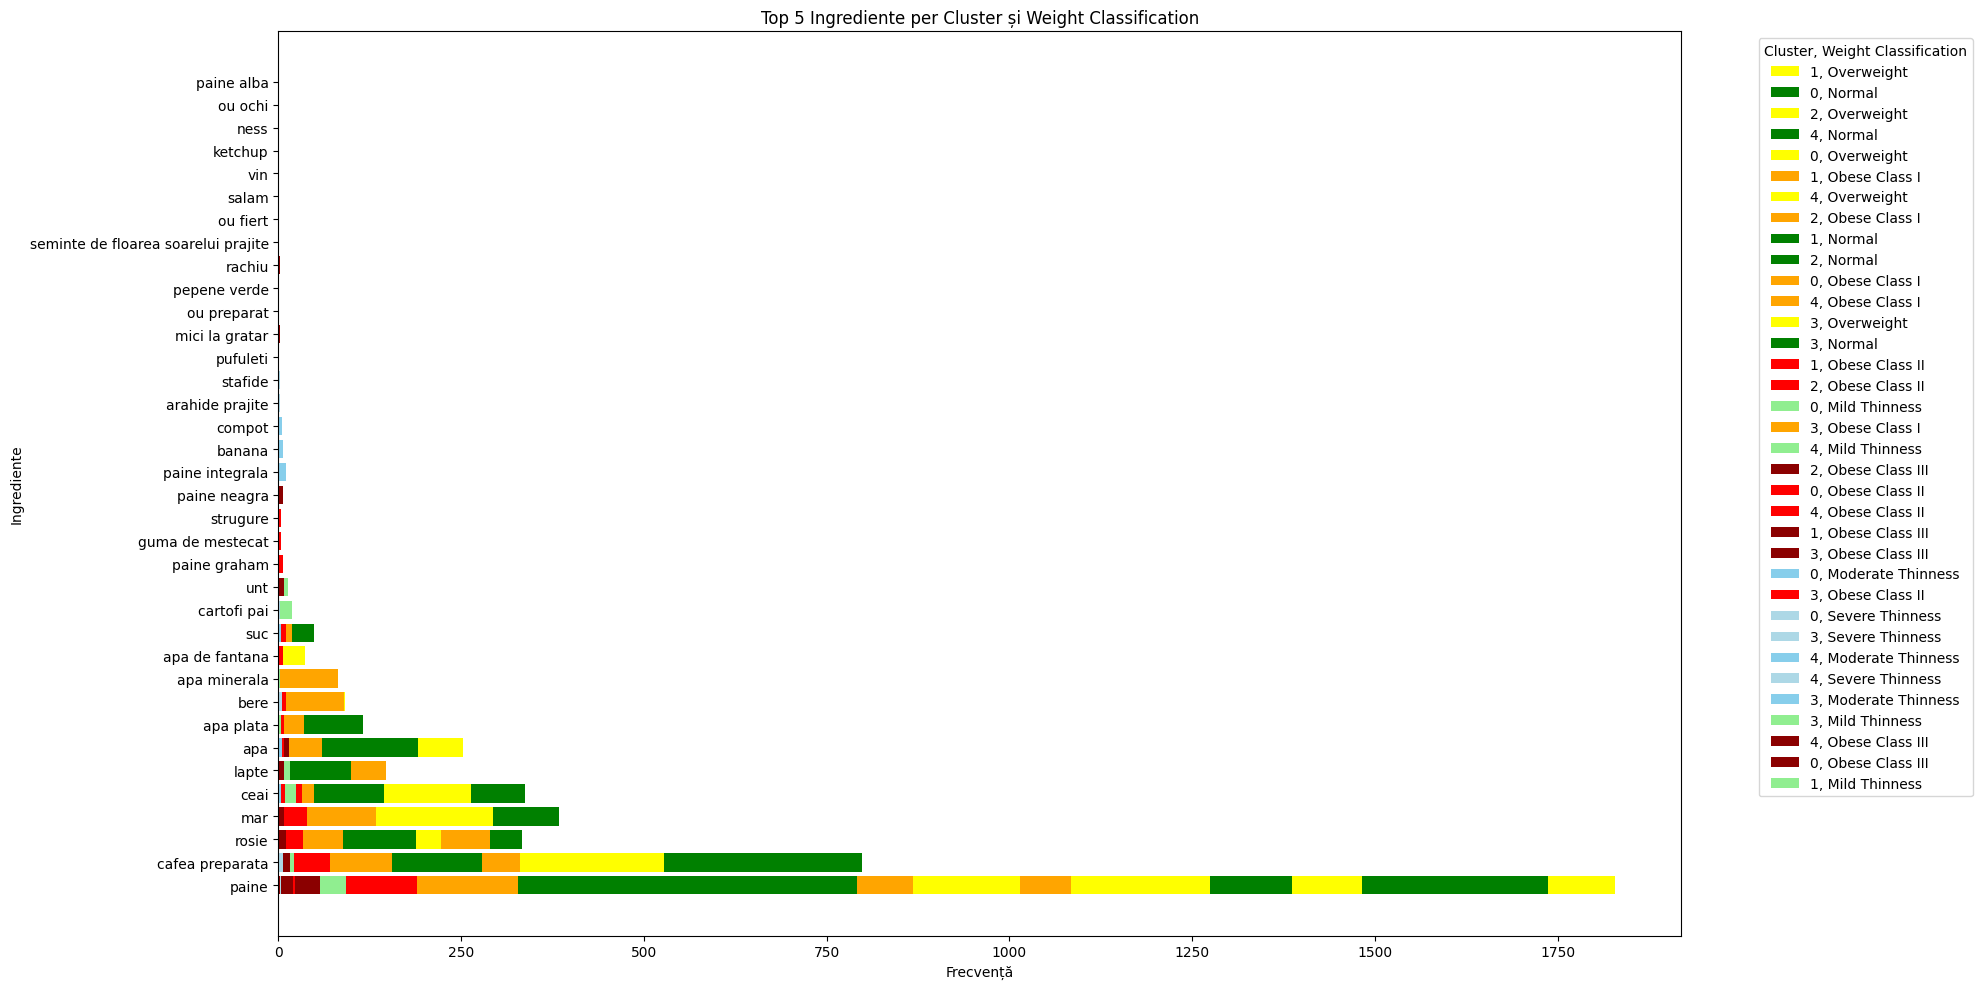

In [117]:
# Încărcarea datelor
top5_recipes_per_cluster_geo = pd.read_csv('statistica1.csv')

# Prelucrarea datelor
top5_recipes_per_cluster_geo['Label'] = top5_recipes_per_cluster_geo['cluster'].astype(str) + ', ' + top5_recipes_per_cluster_geo['WeightClassification'].astype(str)

# Sortarea datelor în funcție de frecvență
top5_recipes_per_cluster_geo_sorted = top5_recipes_per_cluster_geo.sort_values(by='count', ascending=False)

# Definirea culorilor
colors = {
    'Severe Thinness': 'lightblue',
    'Moderate Thinness': 'skyblue',
    'Mild Thinness': 'lightgreen',
    'Normal': 'green',
    'Overweight': 'yellow',
    'Obese Class I': 'orange',
    'Obese Class II': 'red',
    'Obese Class III': 'darkred'
}

# Mărirea dimensiunii graficului
plt.figure(figsize=(20, 10))

# Crearea graficului de tip bar orizontal
for label in top5_recipes_per_cluster_geo_sorted['Label'].unique():
    subset = top5_recipes_per_cluster_geo_sorted[top5_recipes_per_cluster_geo_sorted['Label'] == label]
    weight_classification = label.split(', ')[1]
    color = colors.get(weight_classification, 'grey')
    plt.barh(subset['ORRECIPEDESC'], subset['count'], color=color, label=label)

plt.ylabel('Ingrediente')
plt.xlabel('Frecvență')
plt.title('Top 5 Ingrediente per Cluster și Weight Classification')

# Plasarea legendei în afara graficului
plt.legend(title='Cluster, Weight Classification', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustarea layout-ului pentru a include legenda
plt.tight_layout()

plt.show()

In [118]:
# Calcularea numărului total de rânduri
total_rows = len(dataset_no_duplicates)

# Calcularea numărului de apariții pentru fiecare WeightClassification
weight_classification_counts = dataset_no_duplicates['WeightClassification'].value_counts()

# Calcularea procentajului pentru fiecare WeightClassification
weight_classification_percentages = (weight_classification_counts / total_rows) * 100

# Calcularea numărului de apariții pentru fiecare rețetă
recipe_counts = dataset_no_duplicates['ORRECIPEDESC'].value_counts()

# Calcularea procentajului pentru fiecare rețetă
recipe_percentages = (recipe_counts / total_rows) * 100

# Afișarea procentajelor
print("Procentajul pentru fiecare WeightClassification:")
print(weight_classification_percentages)
contor = 0

# Afișarea procentajului pentru primele 10 rețete
print("\nProcentajul pentru fiecare rețetă:")
for recipe, percentage in recipe_percentages.items():
    print(f"{recipe}: {percentage:.2f}%")
    contor += 1
    if contor >= 10:
        break

Procentajul pentru fiecare WeightClassification:
WeightClassification
Overweight           41.163613
Normal               34.934284
Obese Class I        18.739754
Obese Class II        3.172184
Mild Thinness         1.180582
Obese Class III       0.591010
Moderate Thinness     0.158178
Severe Thinness       0.060395
Name: count, dtype: float64

Procentajul pentru fiecare rețetă:
paine: 19.09%
cafea preparata: 7.30%
rosie: 3.78%
mar: 3.25%
ceai: 3.16%
lapte: 2.32%
apa: 1.76%
branza: 1.49%
strugure: 1.46%
unt: 1.45%
